In [1]:
# CH53のデータをロバストスケーリング、外れ値除外、yeo-ijonson変換の順で平均値信頼区間を求める

from datetime import datetime
from pathlib import Path

# 初期設定値

wav_dir = Path(r"D:\Diana\新千歳空港\WAVE") ## WAVEファイルのパス
stid = "CH53"   ## 測定局ID
calibrated_time = datetime(year=2022,month=12,day=1,hour=0,minute=0,second=0)   ## 校正完了時間
sample_size = 100   ## サンプルサイズ
center_freqs = [250,500,1000,2000]
tap = 1024
percentile = 90
mean_time_sec = 0.1
target_freq = "1000"


In [2]:
# WAVファイルを集める

from datetime import timedelta
import learning_test_func as ln

time = calibrated_time
wav_file_list = []
while len(wav_file_list) < sample_size:
    event_time, path = ln.get_event_time(stid, wav_dir, time)
    if not event_time:
        print("失敗")
        break
    wav_file_list.append(path)
    time = event_time + timedelta(seconds = 1)
print(f"{calibrated_time}～{event_time}")

2022-12-01 00:00:00～2022-12-07 00:46:58


In [3]:
# 実音データから異常検知パラメータを求める

import pandas as pd

columns = list(map(str,center_freqs))
dataset = pd.DataFrame(columns=columns)
for file in wav_file_list:
    fs, signal = ln.wav_load(file)
    oct_freq_masks = ln.make_oct_masks(center_freqs, tap, fs)
    data_list = ln.detect_diff_data(signal, tap, oct_freq_masks, fs, mean_time_sec, percentile)
    dataset = pd.concat([dataset,pd.DataFrame([data_list], columns=columns)], axis=0)

d:\miniconda3\envs\soundvalid\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\noedl\AppData\Local\Temp\ipykernel_9328\2364821262.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\noedl\AppData\Local\Temp\ipykernel_9328\2364821262.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. 

In [4]:
# ロバストスケーリング

from sklearn.preprocessing import RobustScaler
import itertools

rb = RobustScaler(with_centering=False,with_scaling=True)
# pt = PowerTransformer(method="yeo-johnson",standardize=False,copy=True)

r_dataset = {f'{freq}': list() for freq in oct_freq_masks.keys()}
for freq in oct_freq_masks.keys():
    r_df = pd.DataFrame(dataset[freq],copy=True)

    rb.fit(r_df[:])
    r_df[:] = rb.transform(r_df[:])

    r_dataset[freq] = list(itertools.chain.from_iterable(r_df[:].values.tolist()))


In [5]:
# 外れ値を除外する smirnovgrubbs

o_dataset = {f'{freq}': list() for freq in oct_freq_masks.keys()}
for freq in oct_freq_masks.keys():
    o_dataset[freq], out = ln.smirnov_grubbs(list(r_dataset[freq]), 0.05)
    print(out)


[]
[-1.71750558  5.09888766  5.8912959 ]
[-1.62021748 -1.46505466 -1.23740852]
[4.86813126 5.48667528]


In [6]:
# yeo-jhonson変換

from sklearn.preprocessing import PowerTransformer
import itertools

pt = PowerTransformer(method="yeo-johnson",standardize=False,copy=True)

t_dataset = {f'{freq}': list() for freq in oct_freq_masks.keys()}
for freq in oct_freq_masks.keys():
    t_df = pd.DataFrame(o_dataset[freq],copy=True)

    pt.fit(t_df[:])
    t_df[:] = pt.transform(t_df[:])

    t_dataset[freq] = list(itertools.chain.from_iterable(t_df[:].values.tolist()))

サンプルサイズ=100 平均=0.358 標準偏差=0.215 誤差=0.022 歪度=-1.156 尖度=1.843


d:\miniconda3\envs\soundvalid\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


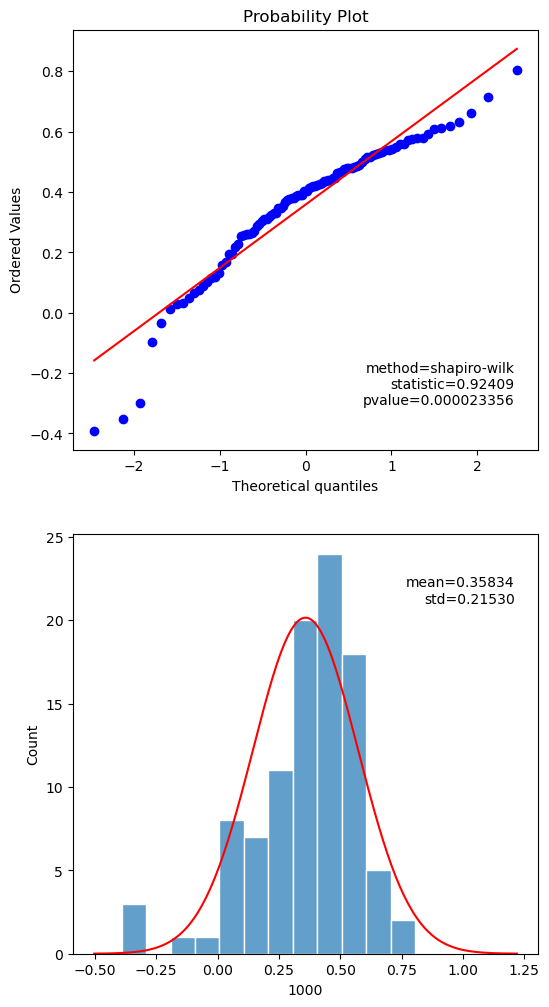

In [7]:
# 求めたパラメータのデータ分布を確認する

from seaborn_analyzer import hist

n,std,se,mean,sk,ku = ln.get_statics(list(dataset[target_freq]))
print(f"サンプルサイズ={n} 平均={mean} 標準偏差={std} 誤差={se} 歪度={sk} 尖度={ku}")

hist.plot_normality(dataset, x=target_freq, norm_hist=False, rounddigit=5)
# all_params, all_scores = hist.fit_dist(dataset, x=target_freq)
# df_scores = pd.DataFrame(all_scores).T

サンプルサイズ=100 平均=1.486 標準偏差=0.893 誤差=0.089 歪度=-1.156 尖度=1.843


d:\miniconda3\envs\soundvalid\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


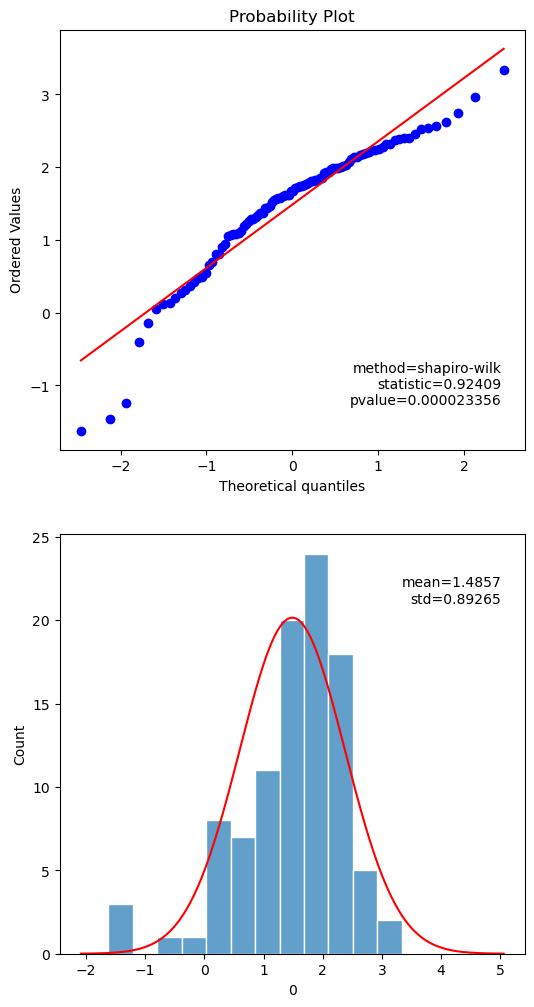

In [8]:
# ロバストスケーリング後のデータ分布を確認する

n,std,se,mean,sk,ku = ln.get_statics(r_dataset[target_freq])
print(f"サンプルサイズ={n} 平均={mean} 標準偏差={std} 誤差={se} 歪度={sk} 尖度={ku}")

df = pd.DataFrame(r_dataset[target_freq],copy=True)
hist.plot_normality(df, x=0, norm_hist=False, rounddigit=5)
# all_params, all_scores = hist.fit_dist(df, x=0, dist=['norm','cauchy'])
# df_scores = pd.DataFrame(all_scores).T

サンプルサイズ=97 平均=1.576 標準偏差=0.738 誤差=0.075 歪度=-0.506 尖度=-0.095


d:\miniconda3\envs\soundvalid\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


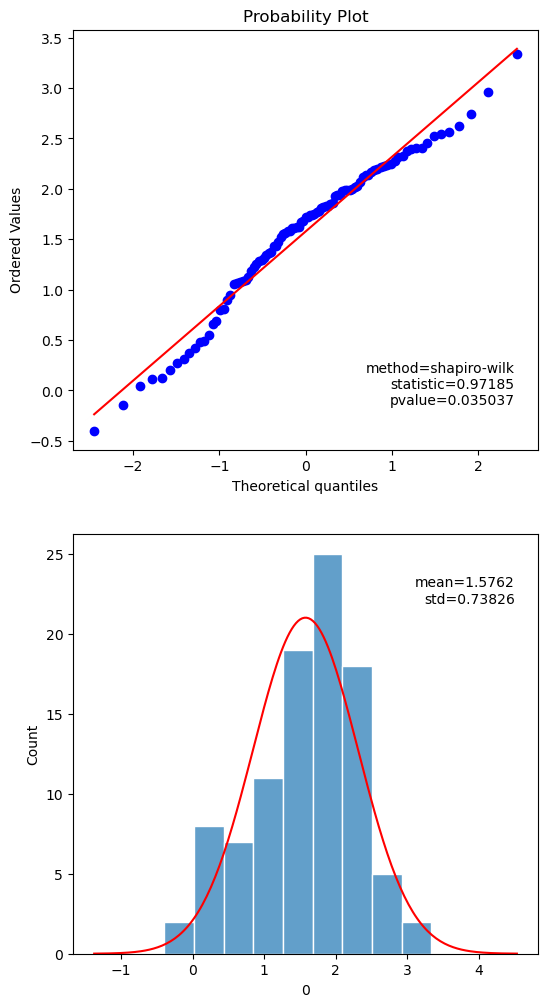

In [9]:
# 外れ値除外後のデータ分布を確認する

n,std,se,mean,sk,ku = ln.get_statics(o_dataset[target_freq])
print(f"サンプルサイズ={n} 平均={mean} 標準偏差={std} 誤差={se} 歪度={sk} 尖度={ku}")

o_df = pd.DataFrame(o_dataset[target_freq],copy=True)
hist.plot_normality(o_df, x=0, norm_hist=False, rounddigit=5)
# all_params, all_scores = hist.fit_dist(o_df, x=0, dist=['norm','cauchy'])
# df_scores = pd.DataFrame(all_scores).T

サンプルサイズ=97 平均=2.216 標準偏差=1.161 誤差=0.118 歪度=-0.099 尖度=-0.228


d:\miniconda3\envs\soundvalid\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


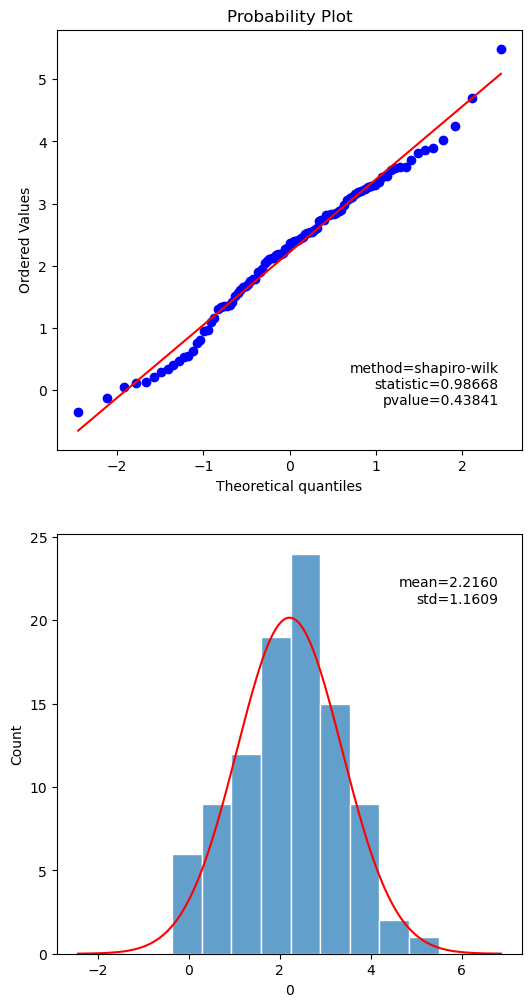

In [10]:
# yeo-jhonson変換後のデータ分布を確認する

n,std,se,mean,sk,ku = ln.get_statics(t_dataset[target_freq])
print(f"サンプルサイズ={n} 平均={mean} 標準偏差={std} 誤差={se} 歪度={sk} 尖度={ku}")

t_df = pd.DataFrame(t_dataset[target_freq],copy=True)
hist.plot_normality(t_df, x=0, norm_hist=False, rounddigit=5)
# all_params, all_scores = hist.fit_dist(t_df, x=0, dist=['norm','cauchy'])
# df_scores = pd.DataFrame(all_scores).T

2.216 1.9819924269379585 2.4499573000748165


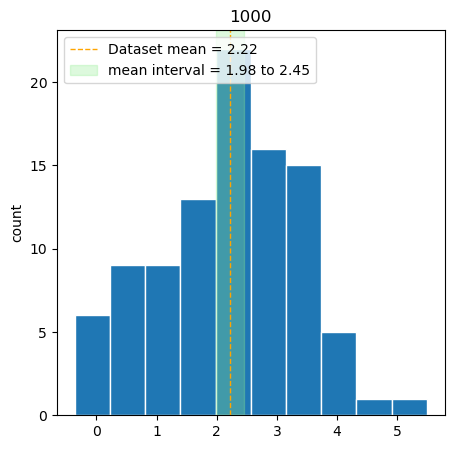

In [11]:
# データセットの平均値信頼区間を求める

import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

t_n = len(t_dataset[target_freq])
t_dof = t_n-1
t_mean = np.mean(t_dataset[target_freq])
t_scale = np.std(t_dataset[target_freq],ddof=1)/np.sqrt(t_n)
t_data = stats.t(loc=t_mean, scale=t_scale, df=t_dof)
bottom, upper = t_data.interval(alpha = 0.95)

print(mean, bottom, upper)

fig = plt.figure(figsize=(5, 5))
plt.hist(t_dataset[target_freq], ec = 'white',)
plt.axvline(t_mean, color='orange', linestyle='dashed', linewidth=1)
plt.axvspan(bottom, upper, color="lightgreen",alpha = 0.3)
plt.ylabel("count")
plt.title(target_freq)
plt.legend([f"Dataset mean = {str(f'{t_mean:.3g}')}",
            f"mean interval = {bottom:.3g} to {upper:.3g}"],
            loc='upper left')


In [12]:
# データの逆変換

inv_stats = pt.inverse_transform(np.array([mean,bottom,upper]).reshape(-1, 1))
inv_stats = rb.inverse_transform(inv_stats)

print(inv_stats)

[[0.3582157 ]
 [0.32477343]
 [0.39101975]]
